In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [2]:
dataset = pd.read_csv('league_of_legends_data_large.csv')

In [3]:
dataset.head()

,win,kills,deaths,assists,gold_earned,cs,wards_placed,wards_killed,damage_dealt
0,0,16,6,19,17088,231,11,7,15367
1,1,8,8,5,14865,259,10,2,38332
2,0,0,17,11,15919,169,14,5,24642
3,0,19,11,1,11534,264,14,3,15789
4,0,12,7,6,18926,124,15,7,40268


In [4]:
x = dataset.iloc[:,1:].values
y = dataset.iloc[:,0].values

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

In [6]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [7]:
x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [8]:
class LRModel(nn.Module):
    def __init__(self,input_dim):
        super(LRModel,self).__init__()
        self.linear = nn.Linear(input_dim,1)

    def forward(self,x):
        x = F.sigmoid(self.linear(x))
        return x

In [9]:
model = LRModel(8)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(),lr = 0.01)

In [19]:
def train_model(model, criterion, optimizer, epochs = 100):

    for epoch in range(1,epochs+1):
        optimizer.zero_grad()
        
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
    
        outputs = (outputs > 0.5).float()
        accuracy = 100 * ((outputs == y_train).sum().item() / y_train.shape[0])

In [21]:
def evaluate_model(model,x,y):
    
    with torch.no_grad():
        outputs = model(x)
        
        outputs = (outputs > 0.5).float()
        accuracy = 100 * ((outputs == y).sum().item() / y.shape[0])
        
        return accuracy

In [23]:
train_model(model,criterion,optimizer)

In [25]:
train_accu = evaluate_model(model,x_train,y_train)
test_accu = evaluate_model(model,x_test,y_test)

In [27]:
print(f'Train Accuracy: {train_accu:.2f}%, Test Accuracy: {test_accu:.2f}%')

Train Accuracy: 45.38%, Test Accuracy: 46.50%


In [29]:
optimizer = optim.SGD(model.parameters(), lr = 0.01, weight_decay = 0.01)
train_model(model,criterion,optimizer)
train_accu = evaluate_model(model,x_train,y_train)
test_accu = evaluate_model(model,x_test,y_test)

In [31]:
print(f'Train Accuracy: {train_accu:.2f}%, Test Accuracy: {test_accu:.2f}%')

Train Accuracy: 45.38%, Test Accuracy: 48.00%


In [33]:
y_pred = (model(x_test) > 0.5).float()
cm = confusion_matrix(y_test,y_pred)
print(cm)

[[53 34]
 [70 43]]


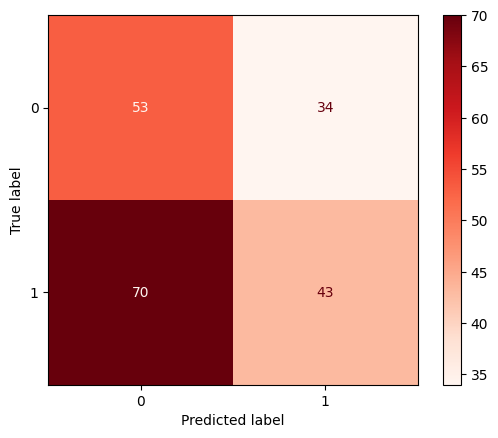

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Reds')
plt.show()

In [36]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

         0.0       0.43      0.61      0.50        87
         1.0       0.56      0.38      0.45       113

    accuracy                           0.48       200
   macro avg       0.49      0.49      0.48       200
weighted avg       0.50      0.48      0.48       200



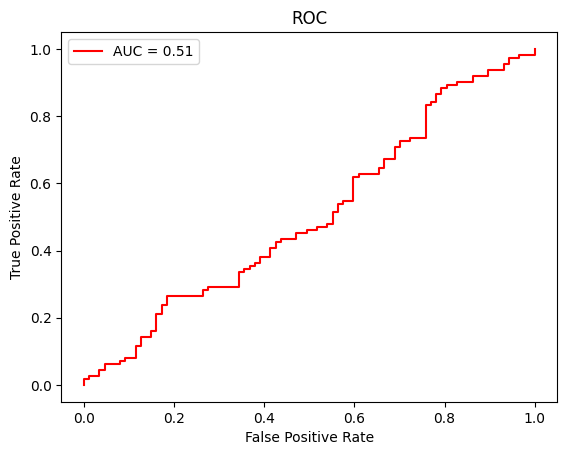

In [39]:
fpr, tpr, _ = roc_curve(y_test,model(x_test).detach().numpy())
plt.plot(fpr,tpr, label = f'AUC = {auc(fpr,tpr):.2f}',color = 'red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
plt.show()

In [41]:
torch.save(model.state_dict(),'model.pth')
loaded_model = LRModel(x_train.shape[1])
loaded_model.load_state_dict(torch.load('model.pth'))
loaded_model.eval()

LRModel(
  (linear): Linear(in_features=8, out_features=1, bias=True)
)

In [43]:
lr_list = [0.1, 0.01, 0.001]
best_accu = 0.0
best_lr = 0.0

for lr in lr_list:
    model = LRModel(x_train.shape[1])  
    optimizer = optim.SGD(model.parameters(), lr=lr)
    train_model(model, criterion, optimizer)  
    accu = evaluate_model(model, x_test, y_test)  
    if accu > best_accu:
        best_lr = lr
        best_accu = accu

print(f'Best Learning Rate: {best_lr}, Accuracy: {best_accu:.4f}')

Best Learning Rate: 0.1, Accuracy: 47.5000


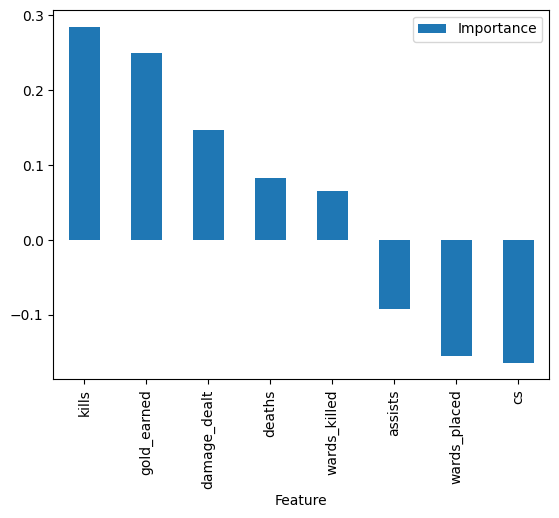

In [45]:
importance = model.linear.weight.detach().numpy().flatten()
x = dataset.iloc[:,1:]
feature_df = pd.DataFrame({'Feature': x.columns, 'Importance': importance})
sorted_df = feature_df.sort_values(by = 'Importance', ascending = False)
sorted_df.plot(kind = 'bar', x = 'Feature', y = 'Importance')
plt.show()